In [1]:
import torch
from diffusers import DDPMPipeline
import matplotlib.pyplot as plt
import torchvision.transforms as T


/home/perann/miniconda3/envs/smc_sampling/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/perann/miniconda3/envs/smc_sampling/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Loading pretrained diff model 

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

pipe = DDPMPipeline.from_pretrained("1aurent/ddpm-mnist").to(device)

pipe.unet.eval()


Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00,  6.41it/s]


UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:34<00:00, 28.61it/s]


(-0.5, 27.5, 27.5, -0.5)

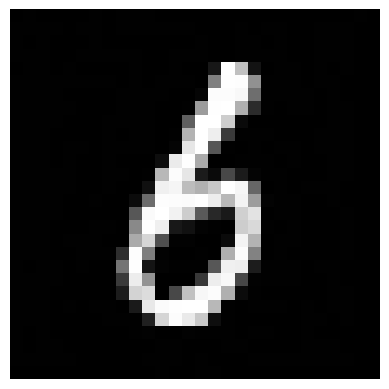

In [4]:
with torch.no_grad():
    image = pipe(batch_size=1).images[0]

plt.imshow(image, cmap="gray")
plt.axis("off")



Inpainting

In [ ]:
def create_inpainting_observation(x_true, missing_ratio=0.6, sigma_noise=0.05):
    """
    x_true: tensor [1, H, W]
    retourne: mask, y
    """
    _, H, W = x_true.shape
    spatial_mask = (torch.rand(H, W, device=x_true.device) > missing_ratio).float()
    mask = spatial_mask.unsqueeze(0)  # broadcast sur le canal

    noise = sigma_noise * torch.randn_like(x_true)
    y = mask * x_true + noise
    return mask, y


def log_likelihood_grad(x, y, mask, sigma_noise):
    """
    Gradient de log p(y|x) pour inpainting
    """
    return mask * (y - mask * x) / (sigma_noise ** 2)


@torch.no_grad()
def guided_reverse_step(pipe, x_t, t, mask, y, sigma_noise, guidance_scale=1.0):
    """
    x_t: [batch, 1, H, W]
    t: int, step
    mask, y: inpainting observation
    guidance_scale: float
    """
    # Prédiction du bruit par le modèle
    eps = pipe.unet(x_t, t).sample

    # Gradient de vraisemblance
    grad = log_likelihood_grad(x_t, y, mask, sigma_noise)

    # Pas reverse DDPM avec guidance
    alpha_t = pipe.scheduler.alphas_cumprod[t]
    alpha_prev = pipe.scheduler.alphas_cumprod[t-1] if t > 0 else torch.tensor(1.0, device=x_t.device)

    x_prev = (
        1 / torch.sqrt(alpha_t) * (x_t - (1 - alpha_t) / torch.sqrt(1 - alpha_t) * eps)
    )

    # Ajouter guidance
    x_prev = x_prev + guidance_scale * grad

    # Ajouter bruit si pas le dernier step
    if t > 0:
        beta_t = 1 - alpha_t
        noise = torch.randn_like(x_t)
        x_prev = x_prev + torch.sqrt(beta_t) * noise

    return x_prev

def smc_guided_sampling(pipe, y, mask, sigma_noise, num_particles=5, num_steps=50, guidance_scale=1.0):
    """
    pipe: DDPMPipeline
    y, mask: observations
    """
    batch_size = 1
    H, W = y.shape[1], y.shape[2]

    # Initialisation des particules
    particles = torch.randn(num_particles, 1, H, W, device=y.device)

    for t in reversed(range(num_steps)):
        for i in range(num_particles):
            particles[i:i+1] = guided_reverse_step(
                pipe, particles[i:i+1], t, mask, y, sigma_noise, guidance_scale
            )

        # Resampling possible selon poids (facultatif pour MNIST simple)

    return particles


In [12]:
import torch
from diffusers import DDPMPipeline, DDPMScheduler
import matplotlib.pyplot as plt
import torchvision.transforms as T

device = "cuda" if torch.cuda.is_available() else "cpu"

# ========================
# 1️⃣ Charger le modèle MNIST
# ========================
pipe = DDPMPipeline.from_pretrained("1aurent/ddpm-mnist").to(device)
pipe.unet.eval()

scheduler = DDPMScheduler.from_config(pipe.scheduler.config)
num_inference_steps = 50
scheduler.set_timesteps(num_inference_steps)

# ========================
# 2️⃣ Générer une image MNIST
# ========================
with torch.no_grad():
    x_true_pil = pipe(batch_size=1).images[0]

to_tensor = T.ToTensor()
x_true = to_tensor(x_true_pil).to(device)
x_true = x_true * 2 - 1  # [-1,1]

# ========================
# 3️⃣ Masque et observation
# ========================
def create_inpainting_observation(x_true, missing_ratio=0.6, sigma_noise=0.05):
    _, H, W = x_true.shape
    spatial_mask = (torch.rand(H, W, device=x_true.device) > missing_ratio).float()
    mask = spatial_mask.unsqueeze(0)
    noise = sigma_noise * torch.randn_like(x_true)
    y = mask * x_true + noise
    return mask, y

sigma_noise = 0.05
mask, y = create_inpainting_observation(x_true, missing_ratio=0.6, sigma_noise=sigma_noise)

# ========================
# 4️⃣ Gradient de log-vraisemblance
# ========================
def log_likelihood_grad(x, y, mask, sigma_noise):
    return mask * (y - mask * x) / (sigma_noise ** 2)

def log_likelihood(x, y, mask, sigma_noise):
    return -0.5 * ((mask * (y - mask * x))**2 / (sigma_noise**2)).sum(dim=[1,2,3])

# ========================
# 5️⃣ SMC-guided sampling avec poids et resampling
# ========================
@torch.no_grad()
def smc_guided_sampling(pipe, y, mask, sigma_noise, num_particles=5, guidance_scale=0.05, num_steps=50):
    _, H, W = y.shape
    particles = torch.randn(num_particles, 1, H, W, device=y.device)  # x_T
    weights = torch.ones(num_particles, device=y.device) / num_particles  # poids initiaux

    timesteps = scheduler.timesteps
    for t_idx, t in enumerate(timesteps):
        for i in range(num_particles):
            x_t = particles[i:i+1]

            # Prédiction epsilon
            eps = pipe.unet(x_t, t)["sample"]

            # Reverse step DDPM
            alpha_t = scheduler.alphas_cumprod[t]
            beta_t = 1 - alpha_t
            x_prev = (1 / torch.sqrt(alpha_t)) * (x_t - (1 - alpha_t) / torch.sqrt(1 - alpha_t) * eps)

            # Guidance gradient
            grad = log_likelihood_grad(x_prev, y, mask, sigma_noise)
            x_prev = x_prev + guidance_scale * grad

            # Ajouter bruit si pas dernier step
            if t_idx < len(timesteps) - 1:
                x_prev = x_prev + torch.sqrt(beta_t) * torch.randn_like(x_prev)

            particles[i:i+1] = x_prev

        # ========================
        # Mise à jour des poids
        # ========================
        logw = log_likelihood(particles, y, mask, sigma_noise)
        logw = logw - logw.max()  # stabilité numérique
        w = torch.exp(logw)
        w = w / w.sum()
        weights = w

        # ========================
        # Resampling multinomial si variance des poids trop grande
        # ========================
        ess = 1.0 / (weights**2).sum()
        if ess < num_particles / 2:
            indices = torch.multinomial(weights, num_particles, replacement=True)
            particles = particles[indices]
            weights = torch.ones(num_particles, device=y.device) / num_particles

    return particles, weights

100%|██████████| 1000/1000 [00:33<00:00, 29.61it/s]


In [13]:
num_particles = 5
particles, weights = smc_guided_sampling(pipe, y, mask, sigma_noise,
                                         num_particles=num_particles,
                                         guidance_scale=0.001,
                                         num_steps=50)



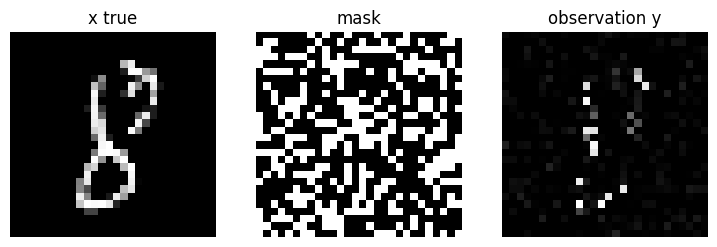

In [14]:
def show(img, title=None):
    img = img.detach().cpu().squeeze(0)
    plt.imshow(img.clamp(0, 1), cmap="gray")
    plt.axis("off")
    if title:
        plt.title(title)

plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
show(x_true, "x true")
plt.subplot(1, 3, 2)
show(mask, "mask")
plt.subplot(1, 3, 3)
show(y, "observation y")
plt.show()


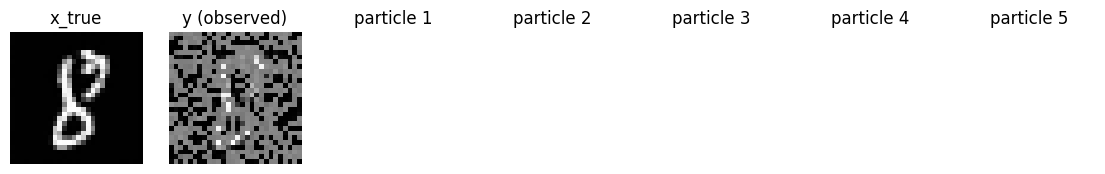

In [15]:
def show(img, title=None):
    img = img.detach().cpu().squeeze(0)
    img = img.clamp(-1, 1)
    img = (img + 1) / 2
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    if title:
        plt.title(title)

plt.figure(figsize=(14, 3))
plt.subplot(1, num_particles+2, 1)
show(x_true, "x_true")
plt.subplot(1, num_particles+2, 2)
show(y, "y (observed)")
for i in range(num_particles):
    plt.subplot(1, num_particles+2, i+3)
    show(particles[i], f"particle {i+1}")
plt.show()


In [16]:
import torch
from diffusers import DDPMPipeline, DDPMScheduler
import matplotlib.pyplot as plt
import torchvision.transforms as T
import os

device = "cuda" if torch.cuda.is_available() else "cpu"

# ========================
# 1️⃣ Charger le modèle MNIST
# ========================
pipe = DDPMPipeline.from_pretrained("1aurent/ddpm-mnist").to(device)
pipe.unet.eval()

scheduler = DDPMScheduler.from_config(pipe.scheduler.config)

# ========================
# 2️⃣ Générer une image MNIST
# ========================
with torch.no_grad():
    x_true_pil = pipe(batch_size=1).images[0]

to_tensor = T.ToTensor()
x_true = to_tensor(x_true_pil).to(device)
x_true = x_true * 2 - 1  # [-1,1]

# ========================
# 3️⃣ Masque et observation
# ========================
def create_inpainting_observation(x_true, missing_ratio=0.6, sigma_noise=0.05):
    _, H, W = x_true.shape
    spatial_mask = (torch.rand(H, W, device=x_true.device) > missing_ratio).float()
    mask = spatial_mask.unsqueeze(0)
    noise = sigma_noise * torch.randn_like(x_true)
    y = mask * x_true + noise
    return mask, y

# Exemple observation
sigma_noise_default = 0.05
mask, y = create_inpainting_observation(x_true, missing_ratio=0.6, sigma_noise=sigma_noise_default)

# ========================
# 4️⃣ Gradient et log-likelihood
# ========================
def log_likelihood_grad(x, y, mask, sigma_noise):
    return mask * (y - mask * x) / (sigma_noise ** 2)

def log_likelihood(x, y, mask, sigma_noise):
    return -0.5 * ((mask * (y - mask * x))**2 / (sigma_noise**2)).sum(dim=[1,2,3])

# ========================
# 5️⃣ SMC-guided sampling avec sauvegarde des étapes
# ========================
@torch.no_grad()
def smc_guided_sampling(pipe, y, mask, sigma_noise, num_particles=5,
                        guidance_scale=0.01, num_steps=50,
                        save_dir="results", show_intermediate=True):

    os.makedirs(save_dir, exist_ok=True)
    _, H, W = y.shape
    particles = torch.randn(num_particles, 1, H, W, device=y.device)  # x_T
    weights = torch.ones(num_particles, device=y.device) / num_particles

    scheduler.set_timesteps(num_steps)
    timesteps = scheduler.timesteps

    for t_idx, t in enumerate(timesteps):
        for i in range(num_particles):
            x_t = particles[i:i+1]

            # Prédiction epsilon
            eps = pipe.unet(x_t, t)["sample"]

            # Reverse step DDPM
            alpha_t = scheduler.alphas_cumprod[t]
            beta_t = 1 - alpha_t
            x_prev = (1 / torch.sqrt(alpha_t)) * (x_t - (1 - alpha_t) / torch.sqrt(1 - alpha_t) * eps)

            # Guidance
            grad = log_likelihood_grad(x_prev, y, mask, sigma_noise)
            x_prev = x_prev + guidance_scale * grad

            # Ajouter bruit sauf dernier step
            if t_idx < len(timesteps) - 1:
                x_prev = x_prev + torch.sqrt(beta_t) * torch.randn_like(x_prev)

            particles[i:i+1] = x_prev

        # Mettre à jour poids
        logw = log_likelihood(particles, y, mask, sigma_noise)
        logw = logw - logw.max()
        w = torch.exp(logw)
        w = w / w.sum()
        weights = w

        # Resampling si ESS faible
        ess = 1.0 / (weights**2).sum()
        if ess < num_particles / 2:
            indices = torch.multinomial(weights, num_particles, replacement=True)
            particles = particles[indices]
            weights = torch.ones(num_particles, device=y.device) / num_particles

        # Sauvegarde et affichage intermédiaire
        if show_intermediate and t_idx % max(1, num_steps // 5) == 0:
            plt.figure(figsize=(15, 3))
            plt.subplot(1, num_particles+2, 1)
            show(x_true, "x_true")
            plt.subplot(1, num_particles+2, 2)
            show(y, "y")
            for j in range(num_particles):
                plt.subplot(1, num_particles+2, j+3)
                show(particles[j], f"step {t_idx} particle {j+1}")
            plt.suptitle(f"Step {t_idx} / {num_steps} | guidance {guidance_scale} | sigma {sigma_noise}")
            plt.savefig(os.path.join(save_dir, f"step_{t_idx}_g{guidance_scale}_s{sigma_noise}.png"))
            plt.close()

    return particles, weights

# ========================
# 6️⃣ Fonction affichage
# ========================
def show(img, title=None):
    img = img.detach().cpu().squeeze(0)
    img = img.clamp(-1, 1)
    img = (img + 1) / 2
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    if title:
        plt.title(title)

# ========================
# 7️⃣ Tester plusieurs combinaisons de paramètres
# ========================
guidance_scales = [0.001, 0.005, 0.01]
num_steps_list = [50, 75]
sigma_noises = [0.03, 0.05]

results_dir = "smc_results"
os.makedirs(results_dir, exist_ok=True)

for g in guidance_scales:
    for s in sigma_noises:
        for n in num_steps_list:
            print(f"Running SMC: guidance={g}, sigma={s}, steps={n}")
            particles, weights = smc_guided_sampling(
                pipe, y, mask, sigma_noise=s,
                num_particles=5,
                guidance_scale=g,
                num_steps=n,
                save_dir=results_dir,
                show_intermediate=True
            )
            # Sauvegarde finale
            for i, p in enumerate(particles):
                plt.figure(figsize=(2,2))
                show(p, f"particle_{i+1}_g{g}_s{s}_n{n}")
                plt.savefig(os.path.join(results_dir, f"particle_{i+1}_g{g}_s{s}_n{n}.png"))
                plt.close()


100%|██████████| 1000/1000 [00:37<00:00, 26.89it/s]


Running SMC: guidance=0.001, sigma=0.03, steps=50
Running SMC: guidance=0.001, sigma=0.03, steps=75
Running SMC: guidance=0.001, sigma=0.05, steps=50
Running SMC: guidance=0.001, sigma=0.05, steps=75
Running SMC: guidance=0.005, sigma=0.03, steps=50
Running SMC: guidance=0.005, sigma=0.03, steps=75
Running SMC: guidance=0.005, sigma=0.05, steps=50
Running SMC: guidance=0.005, sigma=0.05, steps=75
Running SMC: guidance=0.01, sigma=0.03, steps=50
Running SMC: guidance=0.01, sigma=0.03, steps=75
Running SMC: guidance=0.01, sigma=0.05, steps=50
Running SMC: guidance=0.01, sigma=0.05, steps=75


In [20]:
import torch
from diffusers import DDPMPipeline, DDPMScheduler
import matplotlib.pyplot as plt
import torchvision.transforms as T
import os

device = "cuda" if torch.cuda.is_available() else "cpu"

# ========================
# 1️⃣ Charger le modèle MNIST
# ========================
pipe = DDPMPipeline.from_pretrained("1aurent/ddpm-mnist").to(device)
pipe.unet.eval()
scheduler = DDPMScheduler.from_config(pipe.scheduler.config)

# ========================
# 2️⃣ Générer image MNIST
# ========================
with torch.no_grad():
    x_true_pil = pipe(batch_size=1).images[0]

to_tensor = T.ToTensor()
x_true = to_tensor(x_true_pil).to(device)
x_true = x_true * 2 - 1  # [-1,1]

# ========================
# 3️⃣ Masque et observation
# ========================
def create_inpainting_observation(x_true, missing_ratio=0.6, sigma_noise=0.05):
    _, H, W = x_true.shape
    spatial_mask = (torch.rand(H, W, device=x_true.device) > missing_ratio).float()
    mask = spatial_mask.unsqueeze(0)
    noise = sigma_noise * torch.randn_like(x_true)
    y = mask * x_true + noise
    return mask, y

mask, y = create_inpainting_observation(x_true, missing_ratio=0.6, sigma_noise=0.05)

# ========================
# 4️⃣ Gradient
# ========================
def log_likelihood_grad(x, y, mask, sigma_noise):
    return mask * (y - mask * x) / (sigma_noise ** 2)

# ========================
# 5️⃣ Fonction affichage
# ========================
def show(img, title=None):
    img = img.detach().cpu().squeeze(0)
    img = img.clamp(-1, 1)
    img = (img + 1) / 2
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    if title:
        plt.title(title)

# ========================
# 6️⃣ SMC-guided sampling
# ========================
@torch.no_grad()
def smc_guided_sampling(pipe, y, mask, sigma_noise, num_particles=5,
                        guidance_init=0.002, guidance_final=0.0005,
                        num_steps=20, save_dir="smc_grid"):

    os.makedirs(save_dir, exist_ok=True)
    _, H, W = y.shape
    particles = torch.randn(num_particles, 1, H, W, device=y.device)
    weights = torch.ones(num_particles, device=y.device) / num_particles

    scheduler.set_timesteps(num_steps)
    timesteps = scheduler.timesteps

    guidance_schedule = torch.linspace(guidance_init, guidance_final, num_steps)

    for t_idx, t in enumerate(timesteps):
        guidance_scale = guidance_schedule[t_idx]

        for i in range(num_particles):
            x_t = particles[i:i+1]
            eps = pipe.unet(x_t, t)["sample"]

            alpha_t = scheduler.alphas_cumprod[t]
            beta_t = 1 - alpha_t
            x_prev = (1 / torch.sqrt(alpha_t)) * (x_t - (1 - alpha_t) / torch.sqrt(1 - alpha_t) * eps)

            grad = log_likelihood_grad(x_prev, y, mask, sigma_noise)
            x_prev = x_prev + guidance_scale * grad

            if t_idx < len(timesteps) - 1:
                x_prev = x_prev + torch.sqrt(beta_t) * torch.randn_like(x_prev)

            particles[i:i+1] = x_prev

        # Sauvegarde intermédiaire
        plt.figure(figsize=(15,3))
        plt.subplot(1, num_particles+2, 1)
        show(x_true, "x_true")
        plt.subplot(1, num_particles+2, 2)
        show(y, "y")
        for j in range(num_particles):
            plt.subplot(1, num_particles+2, j+3)
            show(particles[j], f"step {t_idx} particle {j+1}")
        plt.suptitle(f"Step {t_idx} | g_init={guidance_init:.4f} | g_final={guidance_final:.4f} | sigma={sigma_noise}")
        plt.savefig(os.path.join(save_dir, f"step_{t_idx}_g{guidance_init}_{guidance_final}_s{sigma_noise}.png"))
        plt.close()

    return particles

# ========================
# 7️⃣ Grille de paramètres
# ========================
guidance_inits = [0.001, 0.0015, 0.002]
guidance_finals = [0.0005, 0.0007, 0.001]
sigma_noises = [0.04, 0.05, 0.06]

num_particles = 5
num_steps = 20
results_dir = "smc_grid_results"
os.makedirs(results_dir, exist_ok=True)

# ========================
# 8️⃣ Boucle sur la grille
# ========================
for g_init in guidance_inits:
    for g_final in guidance_finals:
        for s in sigma_noises:
            print(f"Running SMC: g_init={g_init}, g_final={g_final}, sigma={s}")
            particles = smc_guided_sampling(pipe, y, mask, sigma_noise=s,
                                            num_particles=num_particles,
                                            guidance_init=g_init,
                                            guidance_final=g_final,
                                            num_steps=num_steps,
                                            save_dir=results_dir)

            # Visualiser moyenne et std
            mean_particle = particles.mean(dim=0)
            std_particle = particles.std(dim=0)
            plt.figure(figsize=(6,3))
            plt.subplot(1,2,1)
            show(mean_particle, f"mean g_init={g_init} g_final={g_final} sigma={s}")
            plt.subplot(1,2,2)
            show(std_particle, "std")
            plt.savefig(os.path.join(results_dir, f"mean_std_g{g_init}_{g_final}_s{s}.png"))
            plt.close()


100%|██████████| 1000/1000 [00:38<00:00, 25.88it/s]


Running SMC: g_init=0.001, g_final=0.0005, sigma=0.04
Running SMC: g_init=0.001, g_final=0.0005, sigma=0.05
Running SMC: g_init=0.001, g_final=0.0005, sigma=0.06
Running SMC: g_init=0.001, g_final=0.0007, sigma=0.04
Running SMC: g_init=0.001, g_final=0.0007, sigma=0.05
Running SMC: g_init=0.001, g_final=0.0007, sigma=0.06
Running SMC: g_init=0.001, g_final=0.001, sigma=0.04
Running SMC: g_init=0.001, g_final=0.001, sigma=0.05
Running SMC: g_init=0.001, g_final=0.001, sigma=0.06
Running SMC: g_init=0.0015, g_final=0.0005, sigma=0.04
Running SMC: g_init=0.0015, g_final=0.0005, sigma=0.05
Running SMC: g_init=0.0015, g_final=0.0005, sigma=0.06
Running SMC: g_init=0.0015, g_final=0.0007, sigma=0.04
Running SMC: g_init=0.0015, g_final=0.0007, sigma=0.05
Running SMC: g_init=0.0015, g_final=0.0007, sigma=0.06
Running SMC: g_init=0.0015, g_final=0.001, sigma=0.04
Running SMC: g_init=0.0015, g_final=0.001, sigma=0.05
Running SMC: g_init=0.0015, g_final=0.001, sigma=0.06
Running SMC: g_init=0.002

## **Article version** 

In [ ]:
import torch
import matplotlib.pyplot as plt
from diffusers import DDPMPipeline
import torch.nn.functional as F
import math

In [56]:

device = "cuda" if torch.cuda.is_available() else "cpu"

pipe = DDPMPipeline.from_pretrained("1aurent/ddpm-mnist").to(device)
pipe.unet.eval()

Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00, 13.99it/s]


UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

In [41]:

def mcg_diff_smc_sampler(
    score_model,       # pre‑trained score model (provides score estimates)
    A,                 # forward linear operator (e.g., masking matrix)
    AT,                # adjoint operator of A
    y,                 # measurement data
    sigma_y,           # measurement noise std
    timesteps,         # diffusion timesteps schedule
    num_particles=10,
    resample_threshold_ratio=0.5,
    device='cuda'
):
    """
    Monte Carlo Guided Diffusion (MCGDiff) sampler for Bayesian linear inverse problems.
    This matches the algorithm structure described in Cardoso et al. (MCGDiff). :contentReference[oaicite:2]{index=2}

    score_model: must implement score_model.score(x, t) returning score estimate.
    A, AT: functions implementing forward and adjoint measurement operations.
    y: observed measurement.
    """

    # initialize particles
    particles = torch.randn(num_particles, *y.shape, device=device)
    log_weights = torch.zeros(num_particles, device=device)

    # iterate backwards through diffusion steps
    for t in reversed(timesteps):
        # dt, beta, sqrt_alpha etc. come from your diffusion schedule
        # here we assume `scheduler` holds this information:
        alpha_t = scheduler.alphas_cumprod[t]
        beta_t = 1 - alpha_t

        for i in range(num_particles):
            x = particles[i:i+1]

            # denoise score
            score = score_model.score(x, t)

            # propose backward diffusion step
            # standard reverse step: (simplified Euler‑Maruyama)
            x_mean = (
                x / torch.sqrt(alpha_t)
                - beta_t / torch.sqrt(1 - alpha_t) * score
            )

            noise = torch.randn_like(x)
            x_next = x_mean + torch.sqrt(beta_t) * noise

            # particle becomes proposed sample
            particles[i:i+1] = x_next

        # compute importance weights (log scale)
        # likelihood under measurement model p(y | x) = Normal(A x, sigma_y^2)
        Ax = A(particles)
        log_likelihood = -0.5 * ((Ax - y).pow(2) / sigma_y**2).flatten(1).sum(dim=1)
        log_weights = log_likelihood

        # normalize weights
        logw_max = log_weights.max()
        weights = torch.exp(log_weights - logw_max)
        weights = weights / weights.sum()

        # effective sample size
        ess = 1.0 / (weights**2).sum().item()

        # resample if ESS below threshold
        if ess < num_particles * resample_threshold_ratio:
            indices = torch.multinomial(weights, num_particles, replacement=True)
            particles = particles[indices]
            weights = torch.ones_like(weights) / num_particles

    return particles, weights



Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00, 14.36it/s]


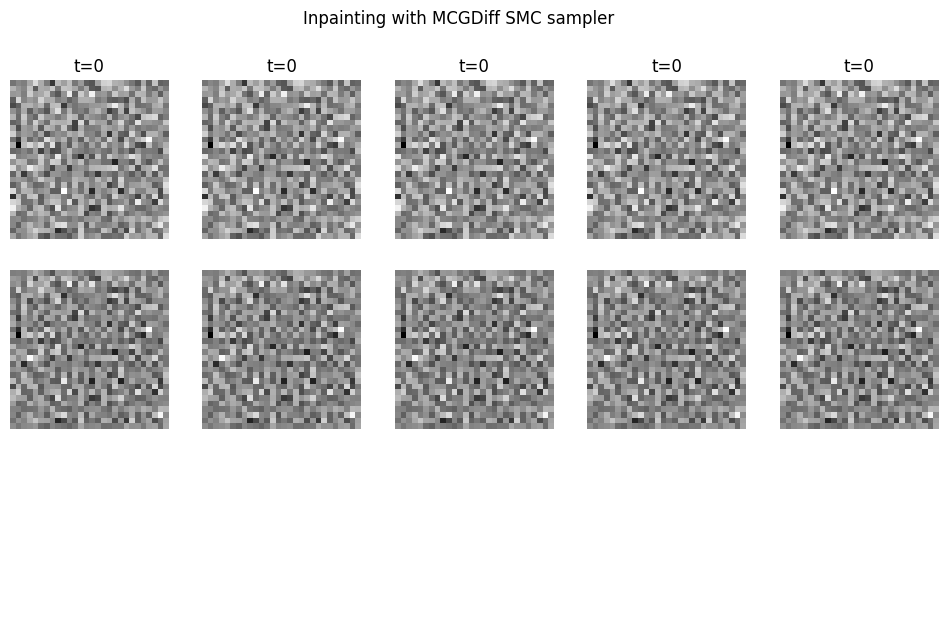

In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"

# ==============================
# Load pre-trained DDPM MNIST model
# ==============================
pipe = DDPMPipeline.from_pretrained("1aurent/ddpm-mnist").to(device)
pipe.unet.eval()

# ==============================
# Load one MNIST image
# ==============================
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to [0,1] tensor
])
mnist_data = MNIST(root="./data", train=False, download=True, transform=transform)
x_true, label = mnist_data[0]  # take the first test image
x_true = x_true.to(device).unsqueeze(0)  # [1,1,28,28]

# ==============================
# Create masked observation (inpainting)
# ==============================
mask = torch.zeros(28,28, device=device)
mask[:, :14] = 1.0  # reveal left half
y = x_true * mask  # masked measurement

def A(x): return x * mask
def AT(x): return x * mask

# ==============================
# Timesteps and score wrapper
# ==============================
timesteps = list(range(100))  # example steps

class ScoreModelWrapper:
    def __init__(self, pipe, timesteps):
        self.pipe = pipe
        self.timesteps = timesteps

    @torch.no_grad()
    def score(self, x, t):
        if x.ndim == 5:
            x = x.squeeze(2)
        eps = self.pipe.unet(x, torch.tensor([t], device=x.device))["sample"]
        alpha_t = 0.01 + 0.99*t/len(self.timesteps)
        return -eps / math.sqrt(1 - alpha_t)

score_model = ScoreModelWrapper(pipe, timesteps)

# ==============================
# Original MCGDiff SMC sampler
# ==============================
def mcg_diff_smc_sampler(
    score_model,
    A,
    AT,
    y,
    sigma_y,
    timesteps,
    num_particles=5,
    resample_threshold_ratio=0.5,
    device='cuda'
):
    particles = torch.randn(num_particles, 1, 28, 28, device=device)
    saved_particles = []

    for t in reversed(timesteps):
        for i in range(num_particles):
            x = particles[i:i+1]
            score = score_model.score(x, t)
            alpha_t = 0.01 + 0.99*t/len(timesteps)
            beta_t = 1 - alpha_t

            # Reverse diffusion proposal
            x_mean = x / math.sqrt(alpha_t) - beta_t / math.sqrt(1 - alpha_t) * score
            x_next = x_mean + math.sqrt(beta_t) * torch.randn_like(x)
            particles[i:i+1] = x_next

        # Compute importance weights
        Ax = A(particles)
        log_weights = -0.5 * ((Ax - y)**2).flatten(1).sum(dim=1)
        logw_max = log_weights.max()
        weights = torch.exp(log_weights - logw_max)
        weights = weights / weights.sum()

        # Resample if ESS is low
        ess = 1.0 / (weights**2).sum().item()
        if ess < num_particles * resample_threshold_ratio:
            indices = torch.multinomial(weights, num_particles, replacement=True)
            particles = particles[indices]
            weights = torch.ones(num_particles, device=device) / num_particles

        saved_particles.append(particles.clone().cpu())

    return saved_particles, weights.cpu()

# ==============================
# Run SMC sampler
# ==============================
saved_particles, final_weights = mcg_diff_smc_sampler(
    score_model=score_model,
    A=A,
    AT=AT,
    y=y,
    sigma_y=0.0,
    timesteps=timesteps,
    num_particles=5,
    device=device
)

# ==============================
# Plot results
# ==============================
fig, axes = plt.subplots(3, 5, figsize=(12, 7))

# Original image
axes[0,0].imshow(x_true[0,0].cpu(), cmap='gray')
axes[0,0].set_title("Original")
axes[0,0].axis("off")

# Masked image
axes[0,1].imshow(y[0,0].cpu(), cmap='gray')
axes[0,1].set_title("Masked input")
axes[0,1].axis("off")

# Plot particles from first, middle, last timesteps
for j, idx in enumerate([0, len(saved_particles)//2, -1]):
    particle_set = saved_particles[idx]
    for i in range(5):
        ax = axes[j,i]
        ax.imshow(particle_set[i,0], cmap='gray')
        if j==0: ax.set_title(f"t={idx}")
        ax.axis("off")

plt.suptitle("Inpainting with MCGDiff SMC sampler")
plt.show()

